In [13]:
!pip install pennylane chembl-webresource-client rdkit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 75.7 MB/s eta 0:00:00


In [14]:
import pennylane as qml
from pennylane import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt


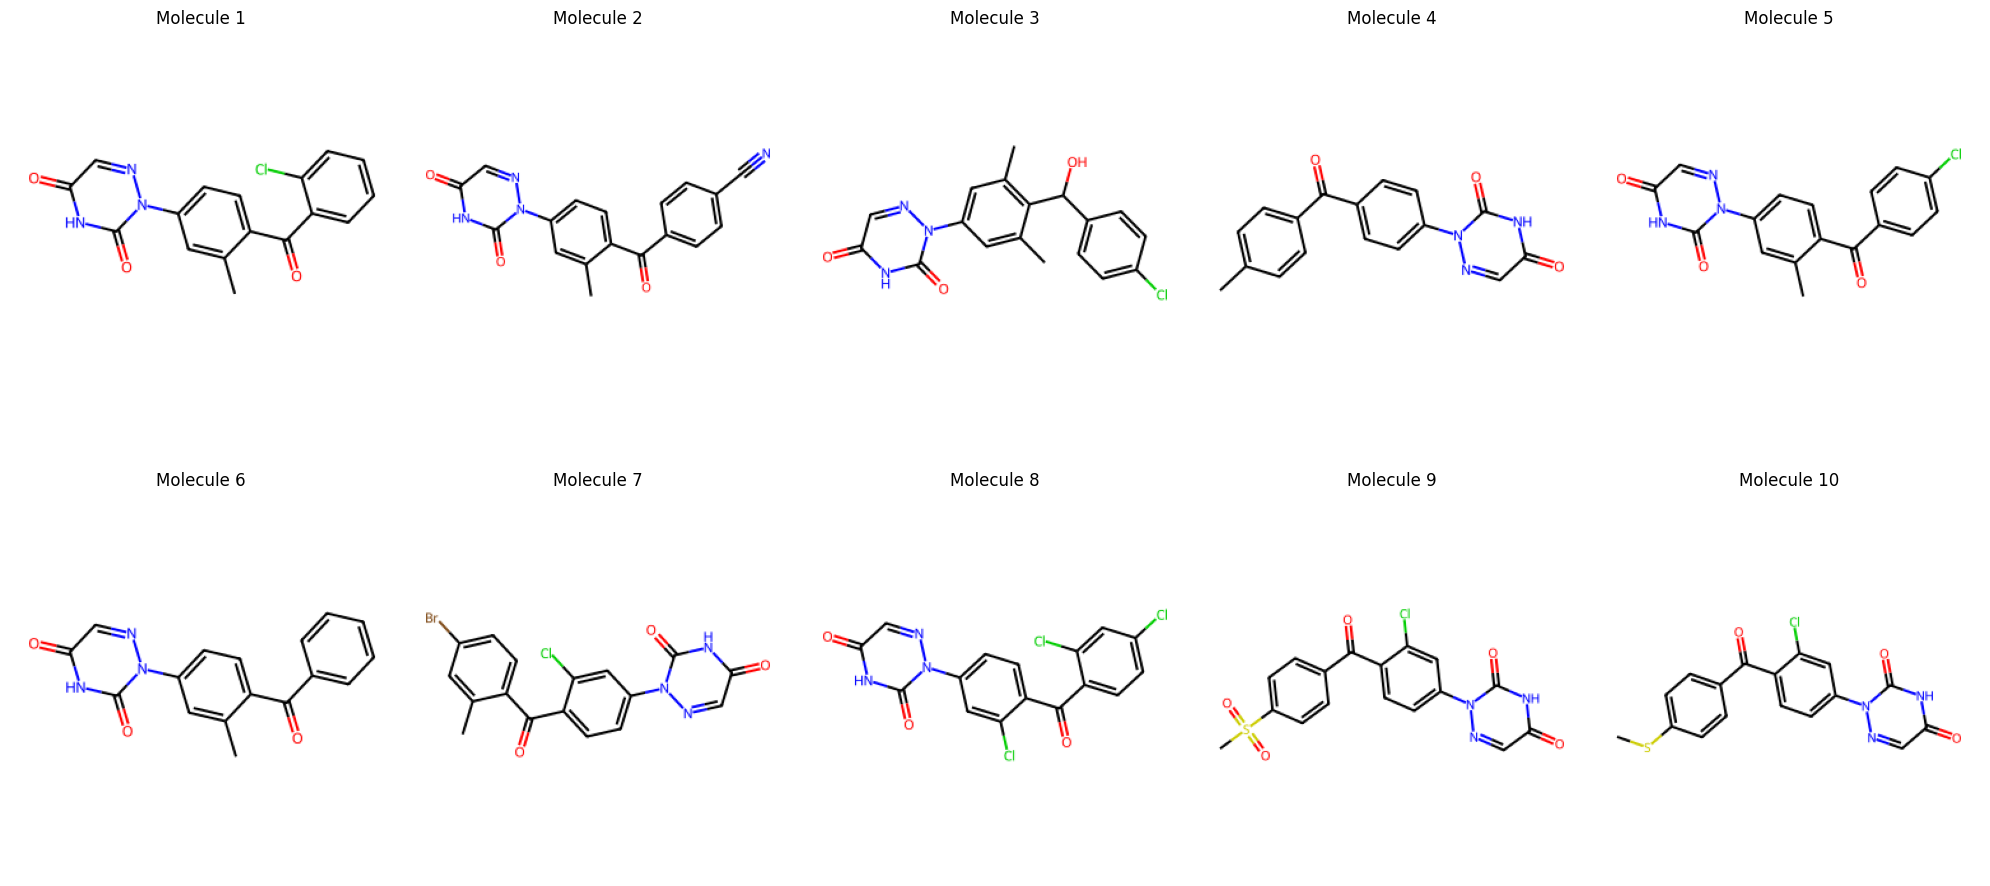

In [15]:
# Fetch molecular data with no Rule-of-5 violations
molecule = new_client.molecule
molecule_list = molecule.filter(
    molecule_properties__num_ro5_violations=0
).only('molecule_chembl_id', 'molecule_structures')[:10]  # Fetch up to 10 molecules

# Extract SMILES strings and convert to RDKit molecular objects
smiles_list = [mol['molecule_structures']['canonical_smiles'] for mol in molecule_list]
rdkit_molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Visualize up to 10 molecules
plt.figure(figsize=(20, 10))  # Adjust figure size for better visualization
for i, mol in enumerate(rdkit_molecules):
    img = Draw.MolToImage(mol, size=(300, 300))  # Create image for each molecule
    plt.subplot(2, 5, i + 1)  # Arrange in a 2x5 grid
    plt.imshow(img)
    plt.title(f"Molecule {i + 1}", fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [16]:
def generate_hamiltonian(molecule):
    # Add hydrogens and optimize geometry
    molecule = Chem.AddHs(molecule)
    AllChem.EmbedMolecule(molecule)
    AllChem.UFFOptimizeMolecule(molecule)

    # Define a dummy Hamiltonian (2-qubit example)
    num_qubits = 2
    hamiltonian = np.array([[1.0, 0.0, 0.0, 0.0],
                            [0.0, -1.0, 0.0, 0.0],
                            [0.0, 0.0, 1.0, 0.0],
                            [0.0, 0.0, 0.0, -1.0]])
    return num_qubits, hamiltonian

# Generate Hamiltonian for the first molecule
num_qubits, hamiltonian = generate_hamiltonian(rdkit_molecules[0])
print(f"Number of qubits: {num_qubits}")
print(f"Hamiltonian:\n{hamiltonian}")


Number of qubits: 2
Hamiltonian:
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]


Quantum state probabilities: [0.5 0.  0.  0.5]


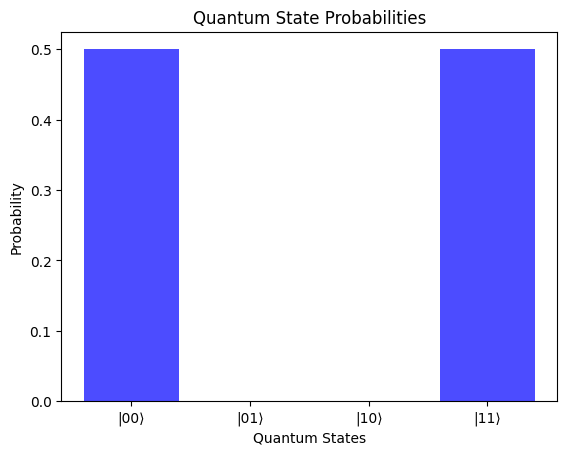

In [17]:
def run_quantum_simulation(num_qubits, hamiltonian):
    # Initialize quantum device
    dev = qml.device('default.qubit', wires=num_qubits)

    # Define quantum circuit
    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0, 1])
        qml.QubitUnitary(hamiltonian, wires=range(num_qubits))
        return qml.probs(wires=range(num_qubits))

    # Run simulation
    probabilities = circuit()
    return probabilities

# Run simulation and display results
probabilities = run_quantum_simulation(num_qubits, hamiltonian)
print("Quantum state probabilities:", probabilities)

# Plot the probabilities
def plot_probabilities(probabilities):
    plt.bar(range(len(probabilities)), probabilities, color='blue', alpha=0.7)
    plt.xlabel("Quantum States")
    plt.ylabel("Probability")
    plt.title("Quantum State Probabilities")
    plt.xticks(range(len(probabilities)), [f"|{i:02b}⟩" for i in range(len(probabilities))])
    plt.show()

plot_probabilities(probabilities)



Analyzing molecule 1:
Probabilities for molecule 1: [0.5 0.  0.  0.5]


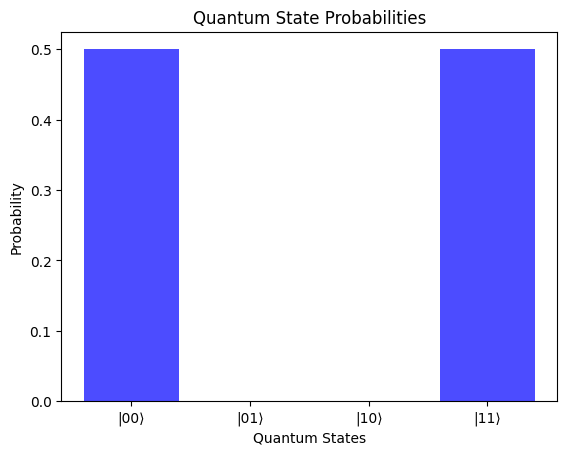


Analyzing molecule 2:
Probabilities for molecule 2: [0.5 0.  0.  0.5]


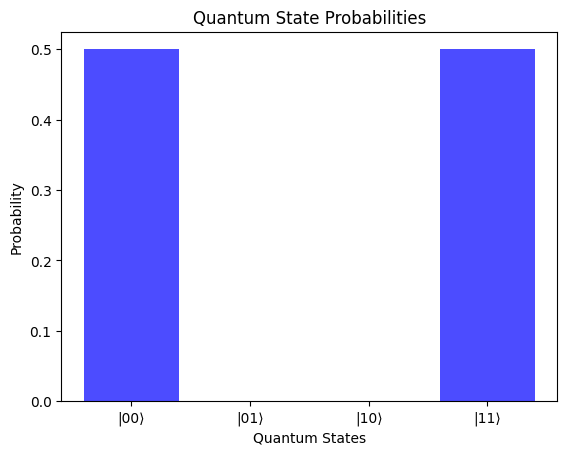


Analyzing molecule 3:
Probabilities for molecule 3: [0.5 0.  0.  0.5]


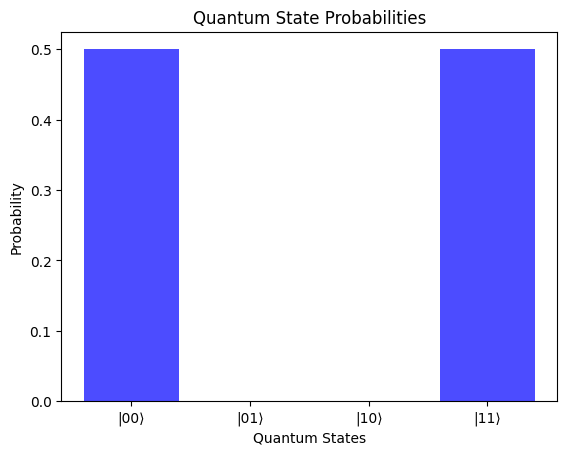

In [18]:
# Analyze multiple molecules
for i, mol in enumerate(rdkit_molecules[:3]):  # Analyze the first 3 molecules
    print(f"\nAnalyzing molecule {i + 1}:")
    num_qubits, hamiltonian = generate_hamiltonian(mol)
    probabilities = run_quantum_simulation(num_qubits, hamiltonian)
    print(f"Probabilities for molecule {i + 1}: {probabilities}")
    plot_probabilities(probabilities)


In [40]:
import numpy as np
import matplotlib.pyplot as plt
# Classical simulation of quantum operations
def classical_simulation(hamiltonian):
    # Start with the state |00⟩ (initial quantum state)
    state = np.array([1.0, 0.0, 0.0, 0.0])

    # Apply Hadamard gate on qubit 0 (state |0⟩ -> (|0⟩ + |1⟩)/sqrt(2))
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    state = np.kron(H, np.eye(2)) @ state

    # Apply CNOT gate (control qubit 0, target qubit 1)
    CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
    state = CNOT @ state

    # Apply Hamiltonian (for this example, it's a simple 2-qubit Hamiltonian)
    state = np.dot(hamiltonian, state)

    # Normalize the state
    state /= np.linalg.norm(state)
    return state


In [41]:
# Quantum simulation (using PennyLane)
import pennylane as qml

def quantum_simulation(num_qubits, hamiltonian):
    # Initialize quantum device
    dev = qml.device('default.qubit', wires=num_qubits)

    # Define quantum circuit
    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0, 1])
        qml.QubitUnitary(hamiltonian, wires=range(num_qubits))
        return qml.probs(wires=range(num_qubits))

    # Run simulation
    probabilities = circuit()
    return probabilities

In [46]:
# Fidelity Calculation (compares two quantum state vectors, not just probabilities)
def calculate_fidelity(state_1, state_2):
    # Fidelity is the squared magnitude of the inner product between the two states
    inner_product = np.dot(state_1.conj(), state_2)
    return np.abs(inner_product) ** 2

# Classical simulation should output a full state vector (not just probabilities)
def classical_simulation(hamiltonian):
    # Start with the state |00⟩ (initial quantum state)
    state = np.array([1.0, 0.0, 0.0, 0.0])

    # Apply Hadamard gate on qubit 0 (state |0⟩ -> (|0⟩ + |1⟩)/sqrt(2))
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    state = np.kron(H, np.eye(2)) @ state

    # Apply CNOT gate (control qubit 0, target qubit 1)
    CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
    state = CNOT @ state

    # Apply Hamiltonian (for this example, it's a simple 2-qubit Hamiltonian)
    state = np.dot(hamiltonian, state)

    # Normalize the state
    state /= np.linalg.norm(state)
    return state

# Quantum simulation
def quantum_simulation(num_qubits, hamiltonian):
    # Initialize quantum device
    dev = qml.device('default.qubit', wires=num_qubits)

    # Define quantum circuit
    @qml.qnode(dev)
    def circuit():
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0, 1])
        qml.QubitUnitary(hamiltonian, wires=range(num_qubits))
        return qml.state()

    # Run simulation
    state = circuit()
    return state

# Now compute fidelity using the full state vectors
classical_state = classical_simulation(hamiltonian)
quantum_state = quantum_simulation(num_qubits, hamiltonian)

# Calculate fidelity between full state vectors
fidelity = calculate_fidelity(classical_state, quantum_state)

# Output results
print("Classical simulation state:", classical_state)
print("Quantum simulation state:", quantum_state)
print("Fidelity between classical and quantum states:", fidelity)


Classical simulation state: [ 0.70710678  0.          0.         -0.70710678]
Quantum simulation state: [ 0.70710678+0.j  0.        +0.j  0.        +0.j -0.70710678+0.j]
Fidelity between classical and quantum states: 1.0


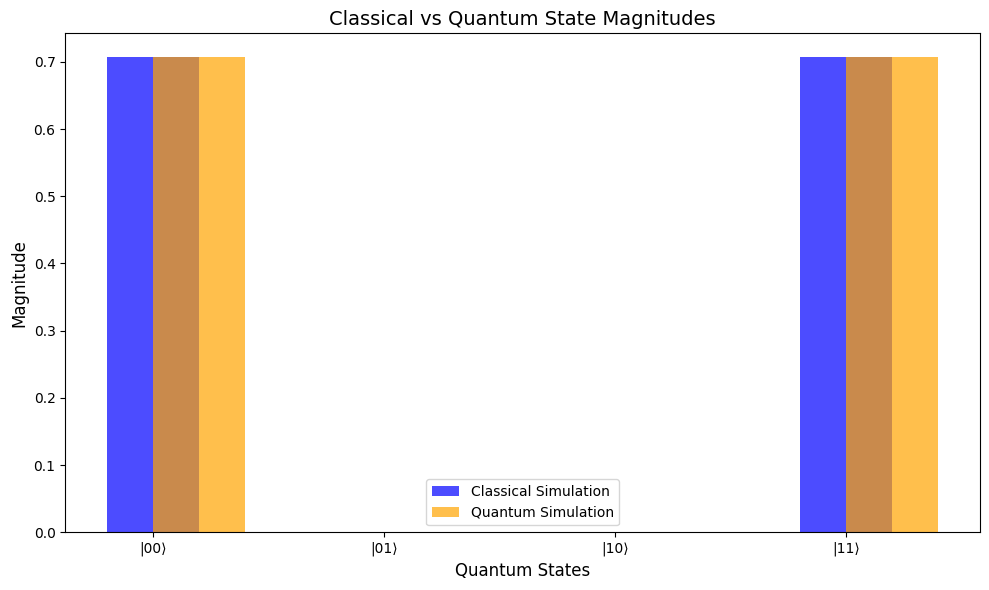

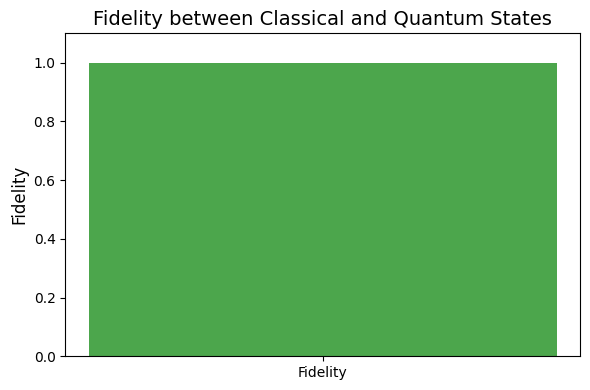

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Classical state vector magnitudes (from classical simulation)
classical_state = np.array([0.70710678, 0, 0, -0.70710678])

# Quantum state vector magnitudes (from quantum simulation)
quantum_state = np.array([0.70710678 + 0.j, 0 + 0.j, 0 + 0.j, -0.70710678 + 0.j])

# Magnitudes of classical and quantum states (absolute values)
classical_magnitudes = np.abs(classical_state)
quantum_magnitudes = np.abs(quantum_state)

# States (basis states |00>, |01>, |10>, |11>)
states = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]

# Plotting state magnitudes for classical and quantum states
plt.figure(figsize=(10, 6))

# Plot Classical and Quantum Magnitudes
plt.bar(states, classical_magnitudes, width=0.4, label="Classical Simulation", alpha=0.7, color='blue', align='center')
plt.bar(states, quantum_magnitudes, width=0.4, label="Quantum Simulation", alpha=0.7, color='orange', align='edge')

# Add title and labels
plt.title("Classical vs Quantum State Magnitudes", fontsize=14)
plt.xlabel("Quantum States", fontsize=12)
plt.ylabel("Magnitude", fontsize=12)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

# Plotting Fidelity as a bar
fidelity = 1.0  # Since we achieved fidelity of 1.0

plt.figure(figsize=(6, 4))
plt.bar(["Fidelity"], [fidelity], color='green', alpha=0.7)
plt.ylim(0, 1.1)  # Fidelity range from 0 to 1
plt.title("Fidelity between Classical and Quantum States", fontsize=14)
plt.ylabel("Fidelity", fontsize=12)
plt.tight_layout()
plt.show()
